In [1]:
import cv2
import numpy as np
import scipy
import glob
from skimage.registration import phase_cross_correlation
from plot_utils import *

### Load images and pre-computed edges from MATLAB

In [2]:
tavg_image_paths = glob.glob('viz_outputs/tavg_20/*.bmp')
tavg_input_images = [cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) for image_path in tavg_image_paths]

matlab_image_paths = glob.glob('viz_outputs/tavg_20_matlab_edges/*.mat')
matlab_input_images = [scipy.io.loadmat(image_path)['img'] for image_path in matlab_image_paths]
matlab_edge_images = [scipy.io.loadmat(image_path)['canny_nml']*255 for image_path in matlab_image_paths]

w_avg_input_images = [scipy.io.loadmat(image_path)['wnr_avg'] for image_path in matlab_image_paths]
w_avg_edge_images = [scipy.io.loadmat(image_path)['canny_avg']*255 for image_path in matlab_image_paths]

w_dsk_input_images = [scipy.io.loadmat(image_path)['wnr_dsk'] for image_path in matlab_image_paths]
w_dsk_edge_images = [scipy.io.loadmat(image_path)['canny_dsk']*255 for image_path in matlab_image_paths]

### Edge Fusion

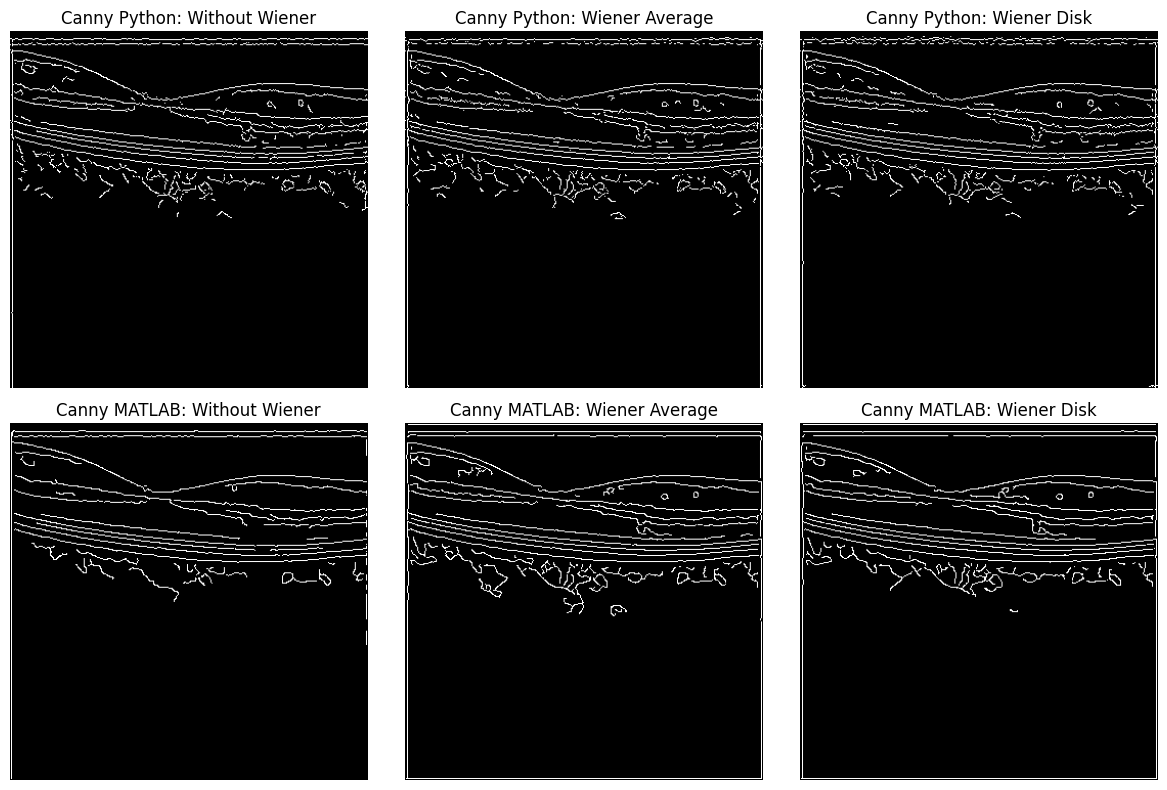

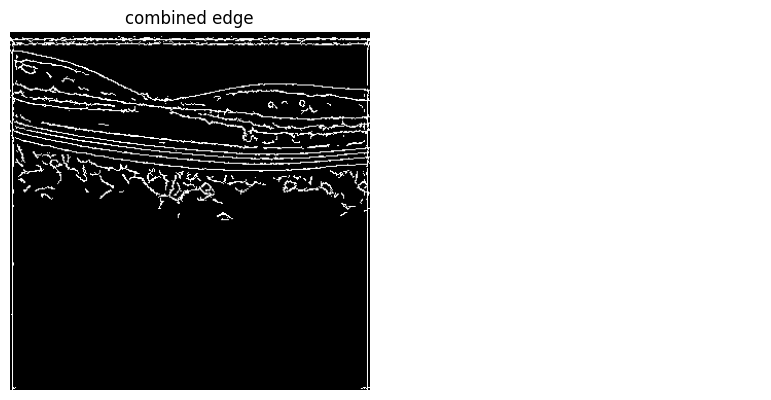

In [3]:
temporal_c1 = cv2.GaussianBlur(tavg_input_images[0], (0, 0), 1.5)
temporal_c1 = cv2.Canny(temporal_c1, 0.1*tavg_input_images[0].max(), 0.15*tavg_input_images[0].max(), 3)
temporal_c2 = cv2.GaussianBlur(w_avg_input_images[0], (0, 0), 1.5)
temporal_c2 = cv2.Canny(temporal_c2, 0.1*w_avg_input_images[0].max(), 0.15*w_avg_input_images[0].max(), 3)
temporal_c3 = cv2.GaussianBlur(w_dsk_input_images[0], (0, 0), 1.5)
temporal_c3 = cv2.Canny(temporal_c3, 0.1*w_dsk_input_images[0].max(), 0.15*w_dsk_input_images[0].max(), 3)

images = [[temporal_c1, temporal_c2, temporal_c3],
          [matlab_edge_images[0], w_avg_edge_images[0], w_dsk_edge_images[0]]]
titles = [['Canny Python: Without Wiener', 'Canny Python: Wiener Average', 'Canny Python: Wiener Disk'],
          ['Canny MATLAB: Without Wiener', 'Canny MATLAB: Wiener Average', 'Canny MATLAB: Wiener Disk']]

edge = np.clip(np.sum(np.array(images), axis=1), 0, 255).astype(np.uint8)[0]

plot_images(images, titles, dpi=100)
plot_images([[edge, None]], [['combined edge']], dpi=100)

### Calculate zero masks

Set the regions affected by 2D image registration earlier to be zero since edges in those areas occur because of temporal averaging

In [4]:
shifts = np.load('viz_outputs/tavg_20/shifts.npy')
shifts.shape

(shift_lr_pos, shift_lr_neg, shift_ud_pos, shift_ud_neg) = shifts[0]

In [5]:
edge_zero = edge.copy()

edge_zero[:shift_ud_pos, :] = 0
edge_zero[shift_ud_neg:, :] = 0
edge_zero[:, :shift_lr_pos] = 0
edge_zero[:, shift_lr_neg:] = 0

### Skeletonization

*Source: https://docs.opencv.org/4.4.0/df/d2d/group__ximgproc.html*

Adding the edge maps from various results causes some edges to be > 1 pixel thickness.  
Use skeletonization to thin out the edge image.

In [6]:
edge_skeleton1 = cv2.ximgproc.thinning(edge_zero, thinningType=cv2.ximgproc.THINNING_ZHANGSUEN)

### Horizontal Erosion and Horizontal Dilation

*Source: https://docs.opencv.org/3.4/dd/dd7/tutorial_morph_lines_detection.html*

Remove vertical lines since we have prior knowledge on our images

In [7]:
verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))

edge_hori1 = cv2.erode(edge_skeleton1, verticalStructure, iterations=1)
edge_hori2 = cv2.dilate(edge_hori1, verticalStructure, iterations=1)
edge_hori2 = cv2.dilate(edge_hori2[:, ::-1], verticalStructure, iterations=1)[:, ::-1]
edge_skeleton2 = cv2.ximgproc.thinning(edge_hori2, thinningType=cv2.ximgproc.THINNING_ZHANGSUEN)

### Edge filtering and cleanup

In [8]:
# Remove edges which are too short
def remove_short_edges(edge_image, min_length=10):
    edge_image = edge_image.copy()
    contours, _ = cv2.findContours(edge_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for contour in contours:
        if len(contour) < min_length:
            cv2.drawContours(edge_image, [contour], 0, 0, -1)
    return edge_image


edge_final = remove_short_edges(edge_skeleton2, min_length=10)

### Process Results

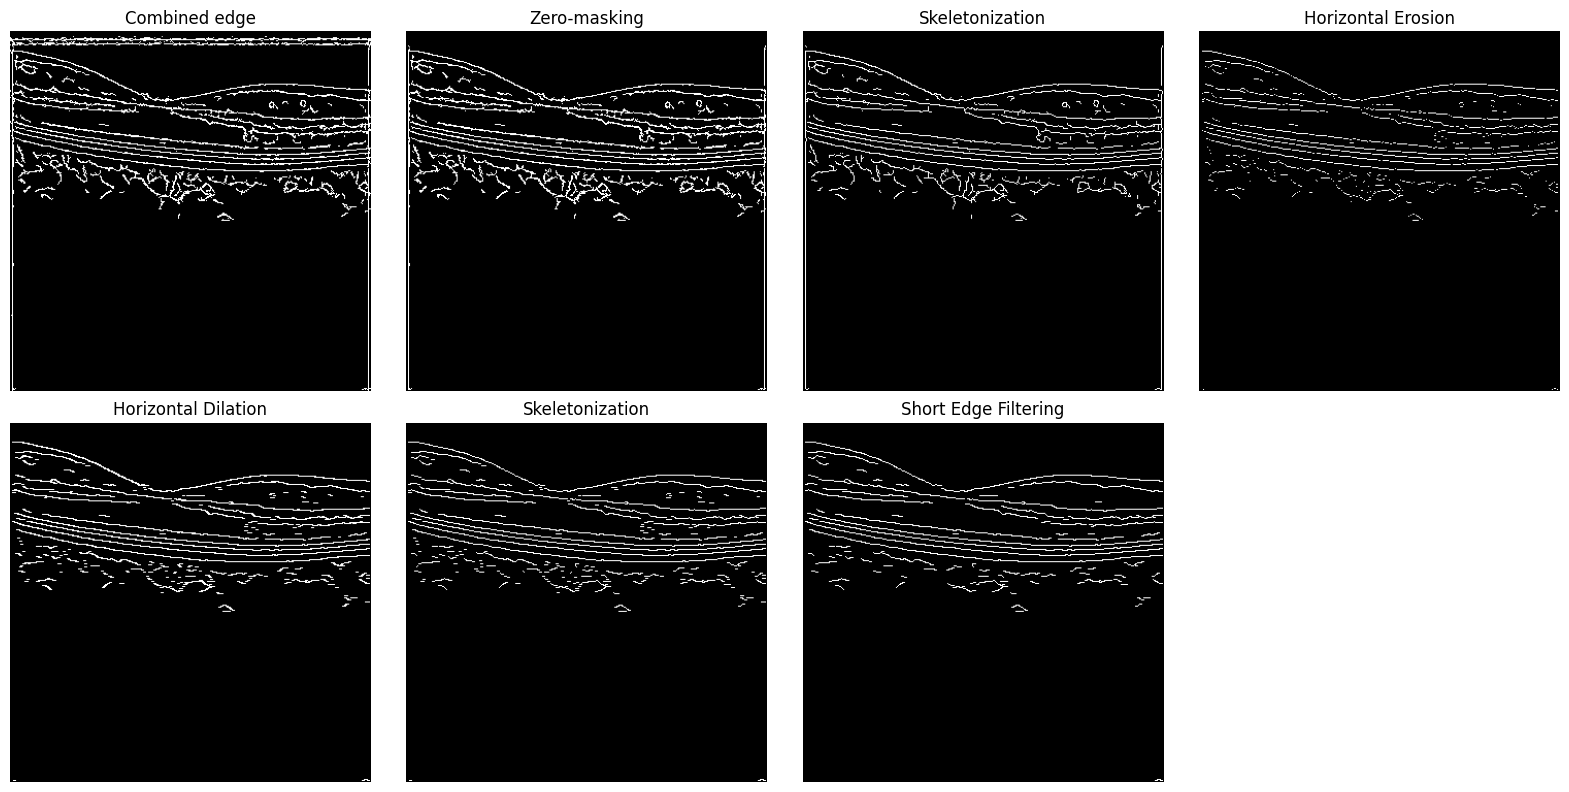

In [9]:
images = [[edge, edge_zero, edge_skeleton1, edge_hori1],
          [edge_hori2, edge_skeleton2, edge_final, None]]
titles = [['Combined edge', 'Zero-masking', 'Skeletonization', 'Horizontal Erosion'],
          ['Horizontal Dilation', 'Skeletonization', 'Short Edge Filtering', '']]

plot_images(images, titles, dpi=100)

### View the blended image

Edge result is superimposed onto the original image

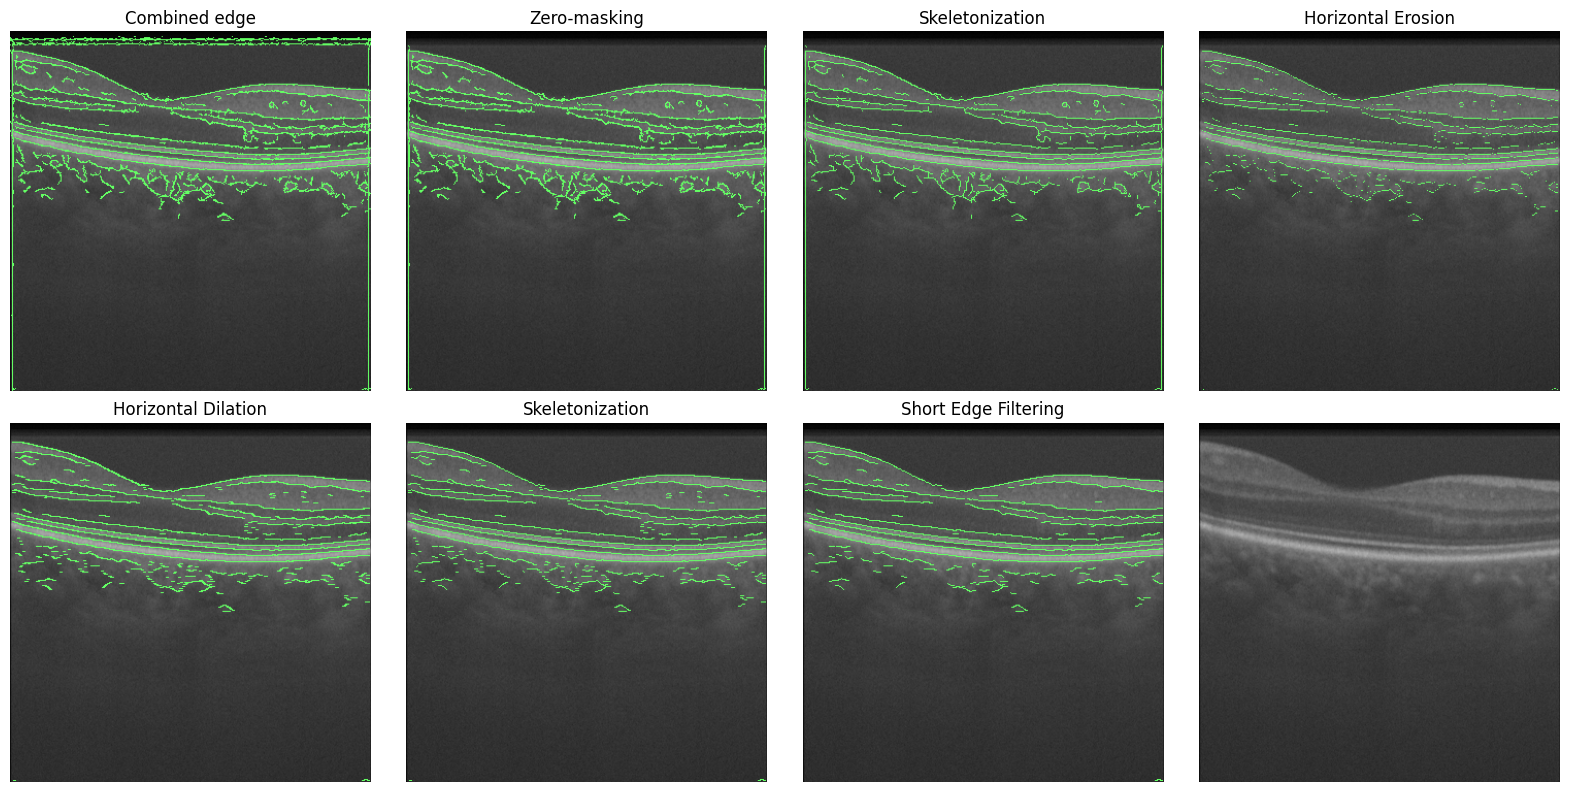

In [10]:
images = [[edge, edge_zero, edge_skeleton1, edge_hori1],
          [edge_hori2, edge_skeleton2, edge_final, None]]
titles = [['Combined edge', 'Zero-masking', 'Skeletonization', 'Horizontal Erosion'],
          ['Horizontal Dilation', 'Skeletonization', 'Short Edge Filtering', '']]

plot_overlay_edges(images, titles, tavg_input_images[0], dpi=100)